<a href="https://colab.research.google.com/github/AndrewMarksArt/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

In [1]:
import numpy as np

np.random.seed(42)
np.random.normal(size=10)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004])

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [2]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [3]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=22.774697660689363, pvalue=1.1338020541271413e-05)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [5]:
import pandas as pd

df = pd.read_csv('https://math.tntech.edu/e-stat/DASL/popularkids.txt', sep='\t')
df.head()

,Gender,Grade,Age,Race,Urban.Rural,School,Goals,Grades,Sports,Looks,Money
0,boy,5,11,White,Rural,Elm,Sports,1,2,4,3
1,boy,5,10,White,Rural,Elm,Popular,2,1,4,3
2,girl,5,11,White,Rural,Elm,Popular,4,3,1,2
3,girl,5,11,White,Rural,Elm,Popular,2,3,4,1
4,girl,5,10,White,Rural,Elm,Popular,4,2,1,3


In [6]:
df.isnull().sum()

Gender         0
Grade          0
Age            0
Race           0
Urban.Rural    0
School         0
Goals          0
Grades         0
Sports         0
Looks          0
Money          0
dtype: int64

In [7]:
table_observed = pd.crosstab(df['Goals'], df['Grade'])
table_observed 

Grade,4,5,6
Goals,,,
Grades,63,88,96
Popular,31,55,55
Sports,25,33,32


In [8]:
table_observed_with_margins = pd.crosstab(df['Goals'], df['Grade'], margins=True)
table_observed_with_margins

Grade,4,5,6,All
Goals,,,,
Grades,63,88,96,247
Popular,31,55,55,141
Sports,25,33,32,90
All,119,176,183,478


In [9]:
table_observed_with_margins['All']

Goals
Grades     247
Popular    141
Sports      90
All        478
Name: All, dtype: int64

In [10]:
table_observed_with_margins.T

Goals,Grades,Popular,Sports,All
Grade,,,,
4,63,31,25,119
5,88,55,33,176
6,96,55,32,183
All,247,141,90,478


In [11]:
table_observed_with_margins.T['All']

Grade
4      119
5      176
6      183
All    478
Name: All, dtype: int64

In [12]:
np.outer(table_observed_with_margins['All'].values[:-1], table_observed_with_margins.T['All'].values[:-1])/table_observed_with_margins.T["All"].values[-1]

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [13]:
goals_totals = table_observed_with_margins['All'].values[:-1]
goals_totals

array([247, 141,  90])

In [14]:
grades_totals = table_observed_with_margins.T['All'].values[:-1]
grades_totals

array([119, 176, 183])

In [15]:
expected = np.outer(goals_totals, grades_totals)/goals_totals.sum()
expected

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [16]:
table_expected = pd.DataFrame(expected)
table_expected.columns = table_observed.columns
table_expected.index = table_observed.index
table_expected

Grade,4,5,6
Goals,,,
Grades,61.491632,90.945607,94.562762
Popular,35.102510,51.916318,53.981172
Sports,22.405858,33.138075,34.456067


In [17]:
deviation = table_observed - table_expected
deviation

Grade,4,5,6
Goals,,,
Grades,1.508368,-2.945607,1.437238
Popular,-4.102510,3.083682,1.018828
Sports,2.594142,-0.138075,-2.456067


In [18]:
deviation_sq = deviation**2
deviation_sq

Grade,4,5,6
Goals,,,
Grades,2.275175,8.676599,2.065654
Popular,16.830592,9.509095,1.038011
Sports,6.729574,0.019065,6.032265


In [19]:
fraction = deviation_sq/table_expected
fraction

Grade,4,5,6
Goals,,,
Grades,0.037000,0.095404,0.021844
Popular,0.479470,0.183162,0.019229
Sports,0.300349,0.000575,0.175071


In [20]:
chi_sq_score = fraction.values.sum()
chi_sq_score

1.3121045153815976

In [0]:
degrees_of_freedom = 4

In [0]:
from scipy.stats import chi2_contingency

In [41]:
chi2, p, dof, expected = chi2_contingency(table_observed)
print(f'chi2: {chi2}')
print(f'P-value: {p}')
print(f'DoF: {dof}')
print(f'expected: {expected}')

chi2: 1.3121045153815976
P-value: 0.8593185000807877
DoF: 4
expected: [[61.4916318  90.94560669 94.56276151]
 [35.10251046 51.91631799 53.98117155]
 [22.40585774 33.13807531 34.45606695]]


# **Confidence Intervals**


In [21]:
import scipy.stats as stats
import numpy as np

# confidence_interval = [lower_bound, upper_bound]

coinflips = np.random.binomial (n=1, p=.501, size=10000000)
print(coinflips[:20])

[1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0]


In [61]:
stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=5.86097518880931, pvalue=4.601710913497208e-09)

In [70]:
coinflips_100 = np.random.binomial(n=1, p=0.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=0.5, size=1000)

print("100 Coin Flips STD:", np.std(coinflips_100))
print("1000 Coin Flips STD:", np.std(coinflips_1000))

100 Coin Flips STD: 0.49183330509431744
1000 Coin Flips STD: 0.49995099759876466


In [0]:
def my_stdev(sample):
  mu = sample.mean()
  diff = sample - mu
  diff_sq = diff**2
  stdev = np.sqrt(diff_sq.sum()/(len(sample)-1))
  return stdev

In [73]:
my_stdev(coinflips_100)/np.sqrt(100), my_stdev(coinflips_1000)/np.sqrt(1000)

(0.04943110704237103, 0.01581774956184353)

In [77]:
delta = coinflips_1000.mean()/np.sqrt(1000)
delta

0.016032747737053685

In [78]:
coinflips_1000.mean() - delta, coinflips_1000.mean(), coinflips_1000.mean() + delta

(0.4909672522629463, 0.507, 0.5230327477370537)

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [22]:
# Load data and print out the first 5 rows
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [0]:
columns = ['Party Affiliation',
          'handicapped-infants',
          'water-project-cost-sharing',
          'adoption-of-the-budget-resolution', 
          'physician-fee-freeze',
          'el-salvador-aid',
          'religious-groups-in-schools',
          'anti-satellite-test-ban', 
          'aid-to-nicaraguan-contras', 
          'mx-missile',
          'immigration',
          'synfuels-corporation-cutback',
          'education-spending', 
          'superfund-right-to-sue',
          'crime',
          'duty-free-exports',
          'export-administration-act-south-africa']

In [24]:
# set column names to the columns list and print out the first 5 rows
df.columns = columns
df.head()

,Party Affiliation,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [0]:
# convert y=1, n=0, and ?=NaN
df = df.replace({'y': 1, 'n': 0, '?': np.NaN})

In [26]:
# count NaN's and fill forward, and backward if needed
df.isnull().sum()

Party Affiliation                           0
handicapped-infants                        12
water-project-cost-sharing                 48
adoption-of-the-budget-resolution          11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               21
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
export-administration-act-south-africa    104
dtype: int64

In [0]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

In [28]:
df.isnull().sum()

Party Affiliation                         0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-corporation-cutback              0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

In [0]:
# seperate republicans and democrats
gop = df[df['Party Affiliation'] == 'republican']
dem = df[df['Party Affiliation'] == 'democrat']

In [0]:
votes = columns[1:]
gop_low_range = []
gop_avg = []
gop_high_range = []

for vote in votes:
  low = gop[vote].mean() - (gop[vote].mean()/np.sqrt(len(gop[vote])) * 2)
  avg = gop[vote].mean()
  high = gop[vote].mean() + (gop[vote].mean()/np.sqrt(len(gop[vote])) * 2)
  
  gop_low_range.append(low)
  gop_avg.append(avg)
  gop_high_range.append(high)

In [0]:
for i in range(len(gop_high_range)):
  if gop_high_range[i] > 1:
    gop_high_range[i] = 1

In [54]:
gop_vote_ranges = pd.DataFrame({'low': gop_low_range, 'avg': gop_avg, 'high': gop_high_range})
gop_vote_ranges = gop_vote_ranges.T
gop_vote_ranges


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
low,0.161085,0.407747,0.110746,0.835629,0.805425,0.76012,0.216458,0.140949,0.095644,0.463120,0.115780,0.699713,0.719849,0.810459,0.090610,0.563798
avg,0.190476,0.482143,0.130952,0.988095,0.952381,0.89881,0.255952,0.166667,0.113095,0.547619,0.136905,0.827381,0.851190,0.958333,0.107143,0.666667
high,0.219867,0.556539,0.151159,1.000000,1.000000,1.00000,0.295447,0.192384,0.130546,0.632119,0.158030,0.955049,0.982532,1.000000,0.123675,0.769536


In [0]:
votes = columns[1:]
dem_low_range = []
dem_avg = []
dem_high_range = []

for vote in votes:
  low = dem[vote].mean() - (dem[vote].mean()/np.sqrt(len(dem[vote])) * 2)
  avg = dem[vote].mean()
  high = dem[vote].mean() + (dem[vote].mean()/np.sqrt(len(dem[vote])) * 2)
  
  dem_low_range.append(low)
  dem_avg.append(avg)
  dem_high_range.append(high)

In [33]:
dem_vote_ranges = pd.DataFrame({'low': dem_low_range, 'avg': dem_avg, 'high': dem_high_range})
dem_vote_ranges = dem_vote_ranges.T
dem_vote_ranges.replace()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
low,0.525904,0.430584,0.765847,0.062451,0.197214,0.417436,0.673814,0.726405,0.644232,0.414149,0.433871,0.128189,0.259665,0.305682,0.548912,0.759274
avg,0.599251,0.490637,0.872659,0.071161,0.224719,0.475655,0.767790,0.827715,0.734082,0.471910,0.494382,0.146067,0.295880,0.348315,0.625468,0.865169
high,0.672598,0.550690,0.979471,0.079871,0.252224,0.533875,0.861766,0.929026,0.823933,0.529671,0.554893,0.163946,0.332095,0.390948,0.702024,0.971063


In [0]:
# plot votes by party with 95% Confidence Intervals

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

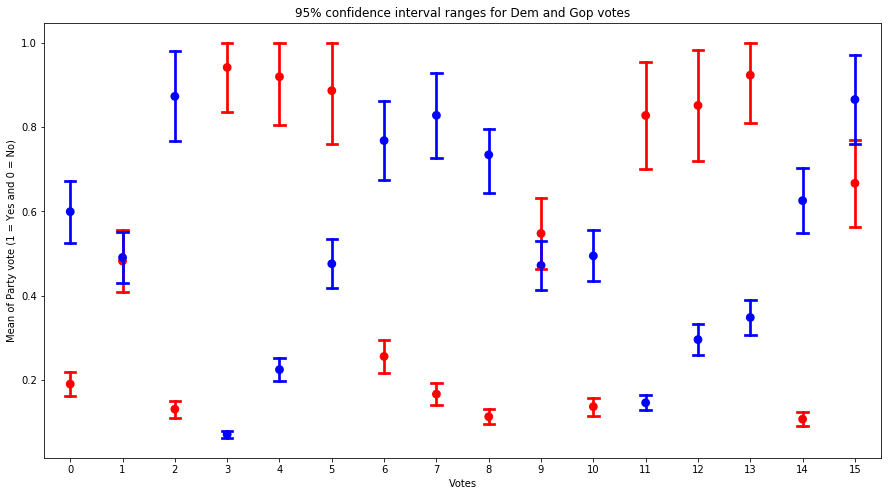

In [55]:
plt.figure(figsize=(15,8))
plt.title("95% confidence interval ranges for Dem and Gop votes")
plt.xlabel("Votes")
plt.ylabel('Mean of Party vote (1 = Yes and 0 = No)')

sns.pointplot(data=gop_vote_ranges, join=False, capsize=.2, color='red')
sns.pointplot(data=dem_vote_ranges, join=False, capsize=.2, color='blue');

From above we can see the confidence intervals and mean of each partys vote across a range of votes. The confidence intervals show us a range of means that if the vote were held 100 times we are confident the mean would fall in this range at least 95 times.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)